In [1]:
# General imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from deepmod_l1.analytical import theta_analytical

#Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Remainder imports
from os import listdir, path, getcwd

# Setting cuda
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining output folder
output_folder = getcwd()

%load_ext autoreload
%autoreload 2

# Making library

In [2]:
D = 0.5
a = 0.25

x = np.linspace(-5, 5, 50, dtype=np.float32)
t = np.linspace(0, 5, 50, dtype=np.float32)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
    
# Analytical
time_deriv, theta = theta_analytical(x_grid, t_grid, D, a)

And performing lst-sq we get:

In [3]:
xi_base = np.linalg.lstsq(theta, time_deriv, rcond=None)[0].squeeze()

In [4]:
xi_base

array([ 3.3292620e-17,  4.8572257e-17,  5.0000000e-01, -3.3306691e-16,
        1.2103378e-16,  4.5970172e-17,  5.8221657e-17, -1.1651528e-16,
       -1.6696713e-16], dtype=float32)

In [159]:
sigma_n = 0.1
noisy = time_deriv + np.random.normal(scale = sigma_n, size=time_deriv.shape)

# Bayesian

To follow Rasmussen, we transpose X and y

In [161]:
cov = 1.0 * np.eye(theta.shape[1])

In [162]:
X = theta.T
y = noisy

In [163]:
A = 1/sigma_n**2 * X @ X.T + np.linalg.inv(cov)
mu = 1/sigma_n**2 * np.linalg.inv(A) @ X @ y

In [164]:
time_deriv_predict_mu = X.T @ mu
time_deriv_predict_s =  np.sqrt(np.diag(X.T @ np.linalg.inv(A) @ X))

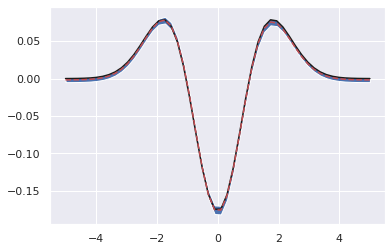

In [165]:
plt.plot(x, time_deriv.reshape(x_grid.shape)[:, 10], 'k')
plt.plot(x, time_deriv_predict_mu.reshape(x_grid.shape)[:, 10], 'r--')
plt.fill_between(x, time_deriv_predict_mu.reshape(x_grid.shape)[:, 10] + time_deriv_predict_s.reshape(x_grid.shape)[:, 10], time_deriv_predict_mu.reshape(x_grid.shape)[:, 10] - time_deriv_predict_s.reshape(x_grid.shape)[:, 10])

In [166]:
time_deriv_predict_s

array([0.00302065, 0.00302065, 0.00302065, ..., 0.00272674, 0.00271608,
       0.00270556])

Error in prediction, good below

# Type II maximizing to find prior

In [277]:
cov = 1.0
noise = 0.1
noisy = time_deriv + np.random.normal(scale = noise, size=time_deriv.shape)


X = torch.tensor(theta, dtype=torch.float32)
y = torch.tensor(noisy, dtype=torch.float32)

In [278]:
alpha = nn.Parameter(torch.tensor(1/cov))
beta = nn.Parameter(torch.tensor(1/noise**2))

In [279]:
A = alpha * torch.eye(X.shape[1]) + beta * X.T @ X
mn = beta * torch.inverse(A) @ X.T @ y

In [280]:
time_deriv_estimate = (X @ mn).detach().cpu().numpy()
time_deriv_sigma = torch.sqrt(1/beta + torch.diag(X @ torch.inverse(A) @ X.T)).detach().cpu().numpy()

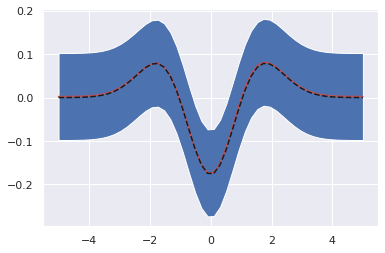

In [281]:
plt.plot(x, time_deriv_estimate.reshape(x_grid.shape)[:, 10], 'r')
plt.fill_between(x, time_deriv_estimate.reshape(x_grid.shape)[:, 10] + time_deriv_sigma.reshape(x_grid.shape)[:, 10], time_deriv_estimate.reshape(x_grid.shape)[:, 10] - time_deriv_sigma.reshape(x_grid.shape)[:, 10])

plt.plot(x, time_deriv.reshape(x_grid.shape)[:, 10], 'k--')

In [210]:
mn

tensor([[ 1.0821e-05],
        [-1.1827e-03],
        [ 5.0146e-01],
        [-2.4348e-04],
        [ 9.3049e-03],
        [-4.5410e-03],
        [ 2.7262e-03],
        [-7.5693e-03],
        [ 2.5932e-03]], grad_fn=<MmBackward>)

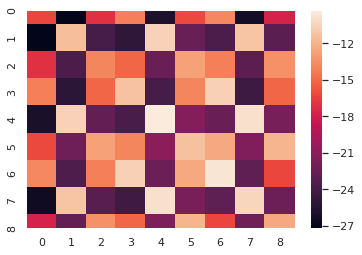

In [211]:
sns.heatmap(np.log(np.abs(torch.inverse(A).cpu().detach().numpy())))

In [282]:
M = X.shape[1]
N = X.shape[0]

In [283]:
E = beta/2 * (y - X @ mn).T @ (y - X @ mn) + alpha/2 * mn.T @ mn
loss = M/2*torch.log(alpha) + N/2 * torch.log(beta) - E - torch.sum(torch.log(torch.diag(torch.cholesky(A))))

In [284]:
noise

0.1

In [294]:
cov = nn.Parameter(torch.tensor(1.0))
noise = nn.Parameter(torch.tensor(1.0))

optimizer = torch.optim.Adam([cov, noise])

In [297]:
for it in np.arange(5000):
    alpha = 1/cov
    beta = 1/noise**2
    A = alpha * torch.eye(X.shape[1]) + beta * X.T @ X
    mn = beta * torch.inverse(A) @ X.T @ y
    E = beta/2 * (y - X @ mn).T @ (y - X @ mn) + alpha/2 * mn.T @ mn
    
    loss = -1 * (M/2*torch.log(alpha) + N/2 * torch.log(beta) - E - torch.sum(torch.log(torch.diag(torch.cholesky(A)))))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if it %500 == 0:
        print(loss, cov, noise)

tensor([[-4475.2793]], grad_fn=<MulBackward0>) Parameter containing:
tensor(0.0287, requires_grad=True) Parameter containing:
tensor(0.1003, requires_grad=True)
tensor([[-4475.2793]], grad_fn=<MulBackward0>) Parameter containing:
tensor(0.0287, requires_grad=True) Parameter containing:
tensor(0.1003, requires_grad=True)
tensor([[-4475.2793]], grad_fn=<MulBackward0>) Parameter containing:
tensor(0.0288, requires_grad=True) Parameter containing:
tensor(0.1003, requires_grad=True)
tensor([[-4475.2788]], grad_fn=<MulBackward0>) Parameter containing:
tensor(0.0287, requires_grad=True) Parameter containing:
tensor(0.1003, requires_grad=True)
tensor([[-4475.2793]], grad_fn=<MulBackward0>) Parameter containing:
tensor(0.0287, requires_grad=True) Parameter containing:
tensor(0.1003, requires_grad=True)
tensor([[-4475.2783]], grad_fn=<MulBackward0>) Parameter containing:
tensor(0.0287, requires_grad=True) Parameter containing:
tensor(0.1003, requires_grad=True)
tensor([[-4475.2788]], grad_fn=<Mu

Heujjj it wortks

Now lets look at the weights:

In [298]:
mn

tensor([[ 0.0025],
        [-0.0071],
        [ 0.4834],
        [ 0.0117],
        [-0.0281],
        [ 0.0540],
        [-0.0360],
        [ 0.0307],
        [-0.0299]], grad_fn=<MmBackward>)

In [301]:
torch.sqrt(torch.diag(torch.inverse(A)))

tensor([0.0029, 0.0282, 0.0099, 0.0334, 0.0789, 0.0341, 0.0718, 0.0486, 0.0196],
       grad_fn=<SqrtBackward>)